# Model Training

## Setting Imports And Loading Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import matplotlib.pyplot as plt

import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import random 
random.seed(4)


df_final = pd.read_csv('../data/processed/df_final_model.csv')

In [2]:
df_final.head(2)

,processed_summary,summary_embedding,model_embedding,word_count,char_count,sentiment,category_binary
0,contact owns 2021 ford f 350 contact received ...,"[-0.5503813028335571, -0.2038578987121582, 0.2...","[0.040037598460912704, -0.27900347113609314, -...",77,565,-0.009091,"[0, 1, 1, 0, 0]"
1,ford knew issue back 2021 filed agency yet wai...,"[-0.12588243186473846, 0.09368353337049484, 0....","[0.040037598460912704, -0.27900347113609314, -...",80,518,0.091667,"[1, 1, 0, 0, 0]"


## Creating Topic Features

In [3]:
# Generatinhg additional features using a topic modeling 
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_final["processed_summary"])

#Model identifies two latent topics in the dataset.
topic_model = LatentDirichletAllocation(n_components=2, random_state=42)
topic_features = topic_model.fit_transform(tfidf_matrix)

topic_df = pd.DataFrame(topic_features, columns=[f"topic_{i+1}" for i in range(topic_features.shape[1])])
df_final = pd.concat([df_final, topic_df], axis=1)

In [4]:
import joblib
# Save the models
joblib.dump(tfidf, "../models/tfidf_vectorizer.pkl")
joblib.dump(topic_model, "../models/lda_model.pkl")

['../models/lda_model.pkl']

In [5]:
# Checking some correlations
df_final.drop(['processed_summary', 'summary_embedding', 'model_embedding', 'category_binary'], axis=1).corr()

,word_count,char_count,sentiment,topic_1,topic_2
word_count,1.000000,0.991726,0.051306,0.086088,-0.086088
char_count,0.991726,1.000000,0.049456,0.012901,-0.012901
sentiment,0.051306,0.049456,1.000000,-0.001529,0.001529
topic_1,0.086088,0.012901,-0.001529,1.000000,-1.000000
topic_2,-0.086088,-0.012901,0.001529,-1.000000,1.000000


## Processing Features for Model Input

In [6]:
# Convert the object columns to a list
df_final["category_binary"] = df_final["category_binary"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final["model_embedding"] = df_final["model_embedding"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final["summary_embedding"] = df_final["summary_embedding"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert embeddings and category binary column to NumPy arrays
X_embeddings = np.array(df_final["summary_embedding"].tolist())
y_category_binary = np.array(df_final["category_binary"].tolist())  # Ensure it's a 2D array
df_final['model_embedding'] = np.array(df_final["model_embedding"].tolist())

# Normalize additional features
additional_features = df_final[['model_embedding','word_count', 'char_count', 'sentiment', 'topic_1', 'topic_2']]
scaler = StandardScaler()
X_additional_features = scaler.fit_transform(additional_features)

# Split data into train and test sets
X_emb_train, X_emb_val, X_add_train, X_add_val, y_train, y_val = train_test_split(
    X_embeddings, X_additional_features, y_category_binary, test_size=0.2, random_state=42
)

# Take the first 10 rows from the validation set for the test set
X_emb_test = X_emb_val[:10]
X_add_test = X_add_val[:10]
y_test = y_val[:10]

# Remove those 10 rows from the validation set
X_emb_val = X_emb_val[10:]
X_add_val = X_add_val[10:]
y_val = y_val[10:]

# Verify the shapes of the data
print("X_emb_train shape:", X_emb_train.shape)  # Should match input shape for embedding input
print("X_add_train shape:", X_add_train.shape)  # Should match input shape for additional input
print("y_train shape:", y_train.shape)          # Should be (num_samples, 5) if 5 labels are expected


X_emb_train shape: (10806, 768)
X_add_train shape: (10806, 6)
y_train shape: (10806, 5)


In [7]:
import json
print("Scaler mean:", scaler.mean_)
print("Scaler scale:", scaler.scale_)

# Define mean and scale values
scaler_data = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}
# Save to JSON file
with open('../models/scaler_params.json', 'w') as f:
    json.dump(scaler_data, f)


Scaler mean: [2.11790538e-02 5.47353420e+01 3.81603568e+02 3.34108170e-03
 6.30761131e-01 3.69238869e-01]
Scaler scale: [1.65505123e-01 3.85491054e+01 2.65486573e+02 1.80745193e-01
 3.42989438e-01 3.42989438e-01]


In [8]:
# Convert arrays to DataFrames
df_emb_test = pd.DataFrame(X_emb_test)
df_add_test = pd.DataFrame(X_add_test)

# Convert multi-label `y_test` into lists (each row is a list of labels)
y_test_lists = [list(row) for row in y_test]

# Combine features and labels into a single DataFrame
df_test_final = pd.DataFrame({
    'embeddings': df_emb_test.values.tolist(),  # Convert rows of feature data to  list
    'additional_features': df_add_test.values.tolist(),  # Convert additional features to list
    'category_binary': y_test_lists  # Store labels as lists
})

# Save to CSV
df_test_final.to_csv("../data/processed/test_data.csv", index=False)

## Creating The Model

This model was chosen over others (BERT, RoBERTa) because it offers a simpler architecture that requires significantly less computational power. 

While transformer models can capture deeper semantic relationships, they are resource intensive. 

Our model effectively handles high-dimensional embeddings with a balance of complexity and performance, making it a practical choice for this task.


In [9]:
# The model uses two input branches: embeddings from complaint texts and structured features. 
# Gaussian noise and dropout improve generalization, while dense layers with batch normalization stabilize learning. 
# The dual-input approach enhances predictions by leveraging both semantic and contextual information. 
# Optimizations like learning rate scheduling, early stopping, and model checkpointing prevent overfitting.
# Additionally, Bayesian optimization was used to select the best hyperparameters, ensuring an efficient and effective search for optimal model configurations.


# Define the model-building function for the tuner
def build_model(hp):
    # Define inputs
    embedding_input = Input(shape=(X_emb_train.shape[1],), name="embedding_input")
    additional_input = Input(shape=(X_add_train.shape[1],), name="additional_input")

    # Add Gaussian noise as a regularization technique
    x1 = GaussianNoise(hp.Float('noise', 0.005, 0.02))(embedding_input)

    # Dense layer for embeddings (input from X_emb_train)
    x1 = Dense(hp.Int('units_x1', 64, 256, step=32), activation='relu', kernel_regularizer=l2(hp.Choice('l2_x1', [0.001, 0.01, 0.1])))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(hp.Float('dropout_x1', 0.2, 0.5))(x1)

    # Dense layer for additional features (input from X_add_train)
    x2 = Dense(hp.Int('units_x2', 32, 128, step=16), activation='relu', kernel_regularizer=l2(hp.Choice('l2_x2', [0.001, 0.01, 0.1])))(additional_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(hp.Float('dropout_x2', 0.2, 0.5))(x2)

    # Concatenate the two blocks of layers
    combined = Concatenate()([x1, x2])
    combined = Dense(hp.Int('units_combined', 16, 64, step=16), activation='relu', kernel_regularizer=l2(hp.Choice('l2_combined', [0.001, 0.01, 0.1])))(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(hp.Float('dropout_combined', 0.2, 0.5))(combined)

    # Output layer for multi-label classification (sigmoid activation for each label)
    output = Dense(5, activation='sigmoid')(combined)

    # Create the model
    model = Model(inputs=[embedding_input, additional_input], outputs=output)

    # Compile the model with Adam optimizer and binary cross-entropy loss for multi-label classification
    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

    return model

# Set up the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',  # Optimize based on validation loss
    max_trials=20,  # Number of trials (different configurations)
    executions_per_trial=1,
    directory="../models/tuner_results", 
    project_name="bayesian_opt_nlp"  
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model_path = "../models/best_model.h5"
model_checkpoint = ModelCheckpoint(filepath=best_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=1e-6)

# Start searching for the best hyperparameters
tuner.search(
    {"embedding_input": X_emb_train, "additional_input": X_add_train},
    y_train,
    validation_data=({"embedding_input": X_emb_val, "additional_input": X_add_val}, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Get the best hyperparameters from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps.values}")

# Train the final model using the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    {"embedding_input": X_emb_train, "additional_input": X_add_train},
    y_train,
    validation_data=({"embedding_input": X_emb_val, "additional_input": X_add_val}, y_val),
    epochs=200,  
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)


Reloading Tuner from ../models/tuner_results\bayesian_opt_nlp\tuner0.json
Best hyperparameters found: {'noise': 0.007875155616146979, 'units_x1': 256, 'l2_x1': 0.001, 'dropout_x1': 0.49870840952907197, 'units_x2': 48, 'l2_x2': 0.001, 'dropout_x2': 0.49462175893319893, 'units_combined': 64, 'l2_combined': 0.01, 'dropout_combined': 0.22088590109147924, 'learning_rate': 0.0008881172270305323}
Epoch 1/200
81/85 [===========================>..] - ETA: 0s - loss: 1.7097 - accuracy: 0.4297 - auc: 0.7039 - recall: 0.6633 - precision: 0.3815
Epoch 1: val_loss improved from inf to 1.27989, saving model to ../models\best_bayesian_model.h5
85/85 [==============================] - 2s 14ms/step - loss: 1.6916 - accuracy: 0.4352 - auc: 0.7080 - recall: 0.6651 - precision: 0.3846 - val_loss: 1.2799 - val_accuracy: 0.4733 - val_auc: 0.7616 - val_recall: 0.5030 - val_precision: 0.5964 - lr: 8.8812e-04
Epoch 2/200
85/85 [==============================] - ETA: 0s - loss: 0.9939 - accuracy: 0.6095 - auc: 0

## Plotting the training results

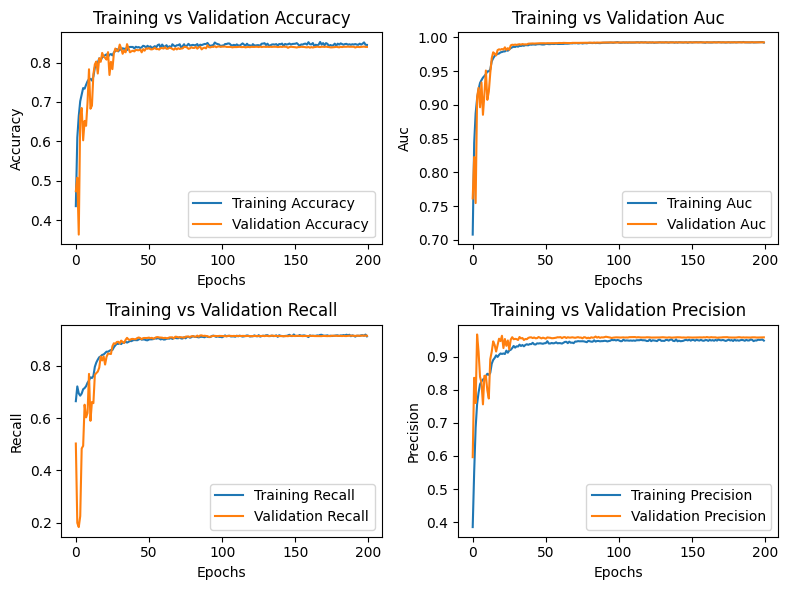

In [10]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'recall', 'precision']

# Create subplots for each metric
plt.figure(figsize=(8, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of plots
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'Training vs Validation {metric.capitalize()}')
    
plt.tight_layout()
plt.show()


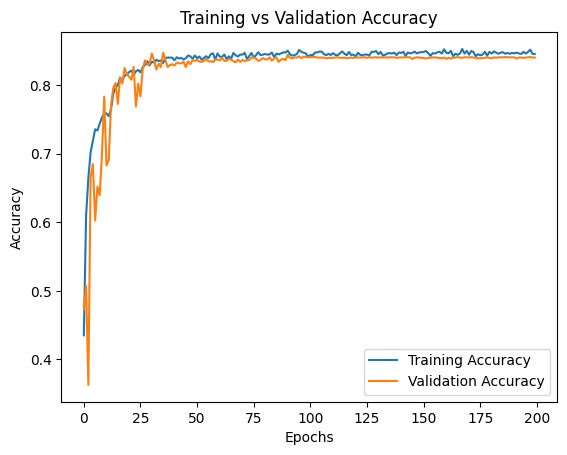

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


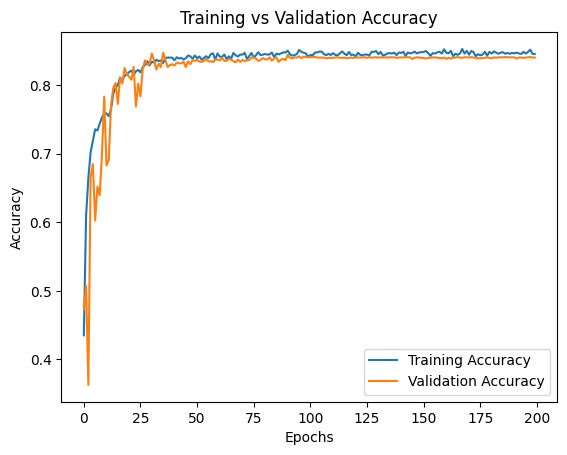

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


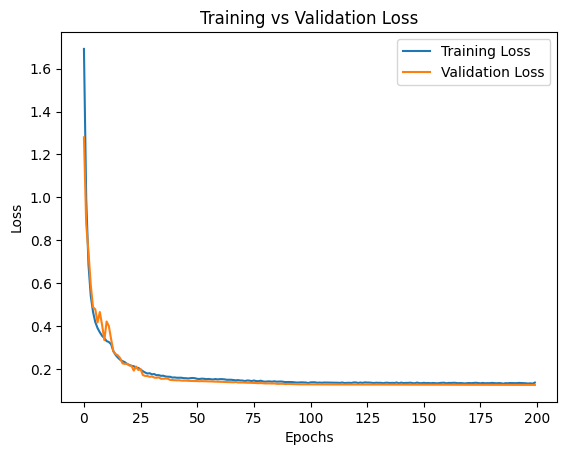

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


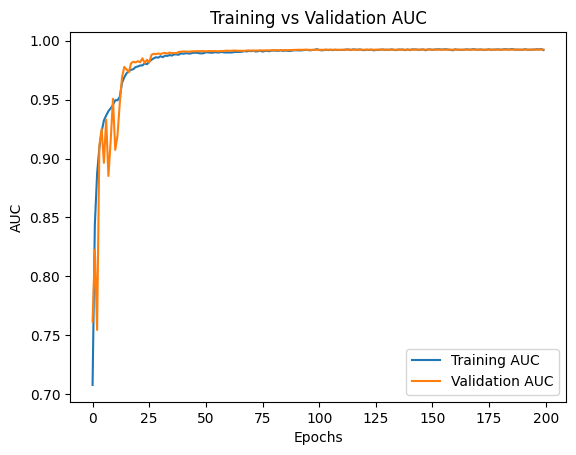

In [14]:
# Plot training and validation accuracy
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Training vs Validation AUC')
plt.show()

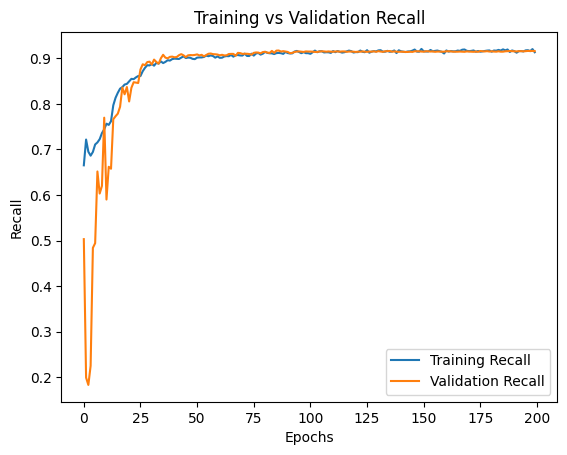

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training vs Validation Recall')
plt.show()

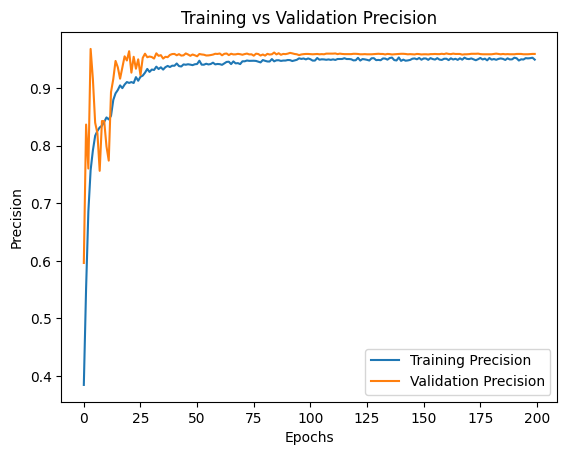

In [16]:
# Plot training and validation accuracy
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training vs Validation Precision')
plt.show()

In [17]:
from tensorflow.keras.models import load_model
model = load_model('../models/best_model.h5')

## Visualizing  And Evaluating The Model Performance For Each Class

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Generate predictions
y_pred_proba = model.predict({"embedding_input": X_emb_val, "additional_input": X_add_val})
y_pred = (y_pred_proba > 0.5).astype(int)

# Multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_val, y_pred)

# Display classification report
print(classification_report(y_val, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))


85/85 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 1       0.97      0.96      0.96       853
     Class 2       0.98      0.96      0.97      1044
     Class 3       0.95      0.93      0.94       730
     Class 4       0.98      0.94      0.96       334
     Class 5       0.97      0.93      0.95       544

   micro avg       0.97      0.95      0.96      3505
   macro avg       0.97      0.94      0.96      3505
weighted avg       0.97      0.95      0.96      3505
 samples avg       0.97      0.96      0.96      3505



c:\Users\dighz\anaconda3\envs\ford_case_iel\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


After evaluating the F1-score, recall and precision metrics we can see that it is not favoring larger categories in a significant way.

Therefore, it is not necessary to apply balancing techniques.

0.9923393556439959
0.9927475077186325
0.9905547875385753
0.9893990644664868
0.992700973545843


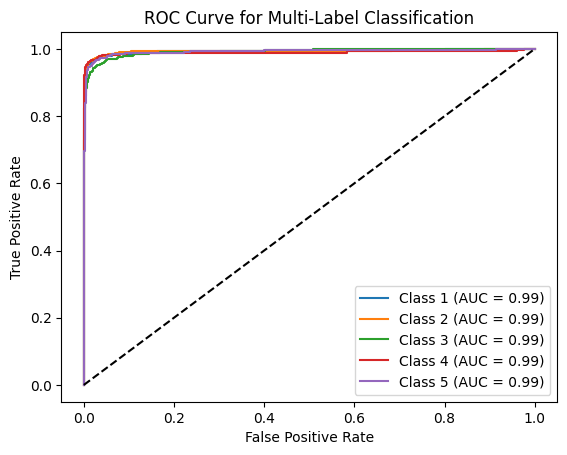

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output (for multi-label ROC)
y_test_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Label Classification')
plt.legend(loc='lower right')
plt.show()
